In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

In [2]:
veriseti = pd.read_csv('./magaza_yorumlari.csv', encoding='utf-16')
print(type(veriseti))
display(veriseti.head())

# Check for null values and remove them
print("\n---null veri seti sayısı----")
print(veriseti.isnull().sum())
veriseti.dropna(inplace=True)
print("\n---temizlemek sonra null sayısı----")
print(veriseti.isnull().sum())


<class 'pandas.core.frame.DataFrame'>


,Görüş,Durum
0,Ürün gayet güzel boyutları dört kişilik aile ...,Olumlu
1,Ürünü kullandım gayet memnunum,Olumlu
2,Hızlı kargo,Olumlu
3,8 yıl önce lg 42 lm serisi almıştım ve tv den ...,Olumsuz
4,ürün fena değil ancak gövdenin plastik olması ...,Olumlu



---null veri seti sayısı----
Görüş    2
Durum    0
dtype: int64

---temizlemek sonra null sayısı----
Görüş    0
Durum    0
dtype: int64


In [3]:
label_mapping = {'Olumsuz': 0, 'Olumlu': 1}
veriseti['Durum'] = veriseti['Durum'].map(label_mapping)
display(veriseti.head())

,Görüş,Durum
0,Ürün gayet güzel boyutları dört kişilik aile ...,1
1,Ürünü kullandım gayet memnunum,1
2,Hızlı kargo,1
3,8 yıl önce lg 42 lm serisi almıştım ve tv den ...,0
4,ürün fena değil ancak gövdenin plastik olması ...,1


In [4]:
# Download NLTK stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Initialize Turkish stopwords and stemmer
ineffective = stopwords.words('turkish')

# Define text cleaning and normalization functions
def clean_and_normalize_text(text):
    unwanted_pattern = r'[!.\n,:“”,?@#/"]'
    regex = re.compile(unwanted_pattern)
    cleaned_text = regex.sub(" ", text)
    cleaned_text = re.sub(r'\d+', '', cleaned_text)
    cleaned_text = cleaned_text.lower()
    
    tokens = nltk.word_tokenize(cleaned_text)
    tokens = [word for word in tokens if word not in ineffective]
    return ' '.join(tokens)

# Apply text cleaning and normalization
veriseti['new_text'] = veriseti['Görüş'].astype(str).apply(clean_and_normalize_text)
display(veriseti.head(5000))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\modek\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\modek\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\modek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,Görüş,Durum,new_text
0,Ürün gayet güzel boyutları dört kişilik aile ...,1,ürün gayet güzel boyutları dört kişilik aile y...
1,Ürünü kullandım gayet memnunum,1,ürünü kullandım gayet memnunum
2,Hızlı kargo,1,hızlı kargo
3,8 yıl önce lg 42 lm serisi almıştım ve tv den ...,0,yıl önce lg lm serisi almıştım tv den gayet me...
4,ürün fena değil ancak gövdenin plastik olması ...,1,ürün fena değil ancak gövdenin plastik olması ...
...,...,...,...
4995,idare eder ://///,0,idare eder
4996,ürünü begenmem icin urunun gelmesi lazim.ama o...,0,ürünü begenmem icin urunun gelmesi lazim ortad...
4997,Ürünü satıncaya kadar çok iyi 2 yıl garanti bi...,0,ürünü satıncaya kadar iyi yıl garanti bitince ...
4998,rengi mutfagima aradigim bir tondu.islevide ga...,1,rengi mutfagima aradigim bir tondu islevide ga...


In [5]:
# Split the data into training and testing sets
X_tr,X_te,Y_tr,Y_te = train_test_split(veriseti['new_text'], veriseti['Durum'], test_size=0.2, random_state=123)

# Define a TF-IDF Vectorizer
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_tr)
X_test_tfidf = tfidf.transform(X_te)

Model: LogisticRegression
Accuracy: 0.8904593639575972


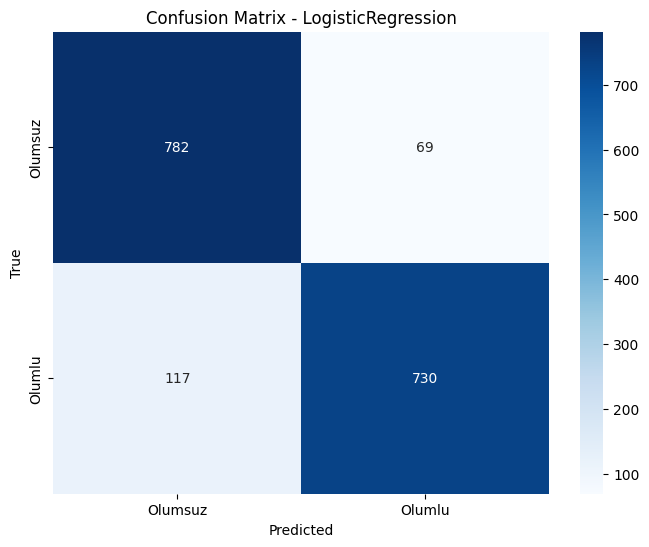

Model: SVC
Accuracy: 0.8916372202591284


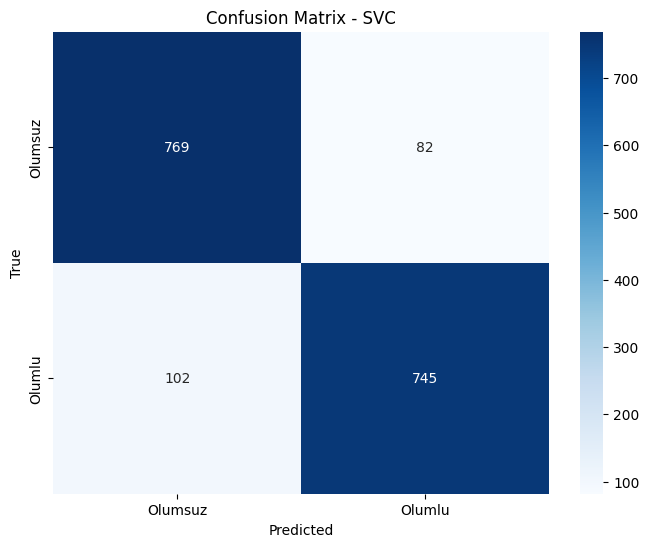

Model: RandomForestClassifier
Accuracy: 0.8627797408716137


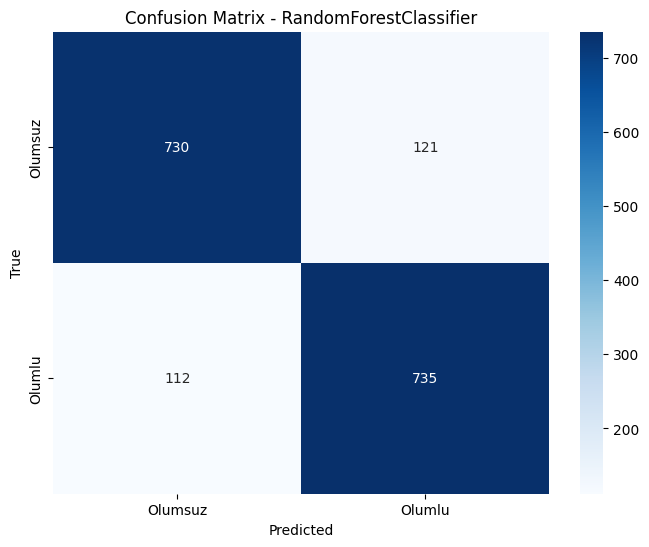

Model: GradientBoostingClassifier
Accuracy: 0.8239104829210836


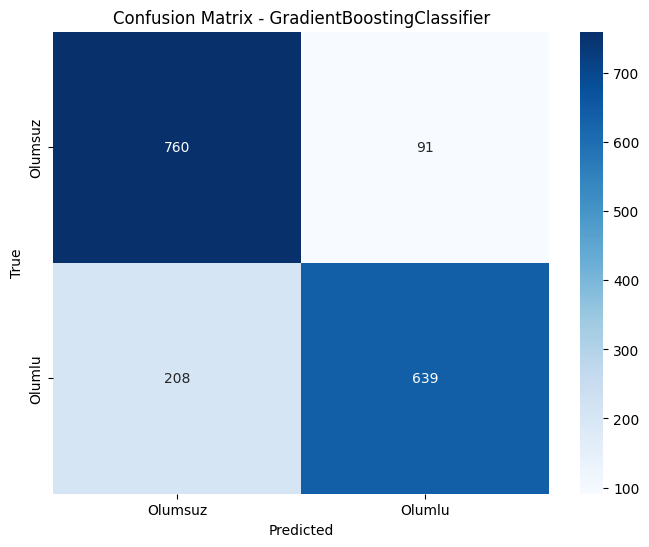

Model: MultinomialNB
Accuracy: 0.8898704358068316


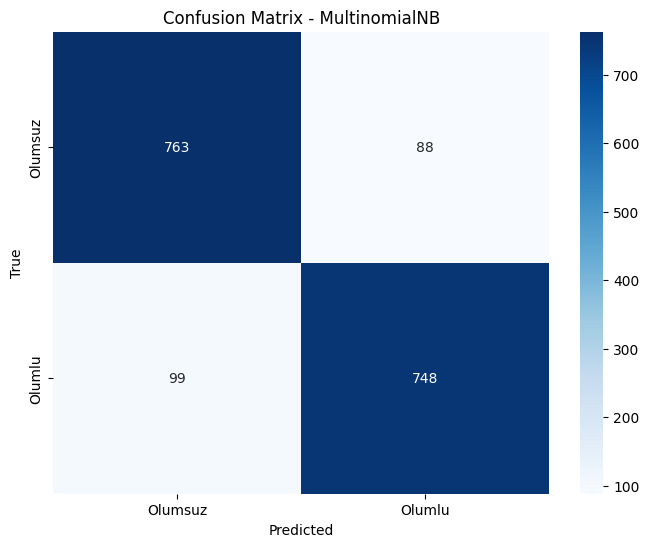

Model: XGBClassifier
Accuracy: 0.85924617196702


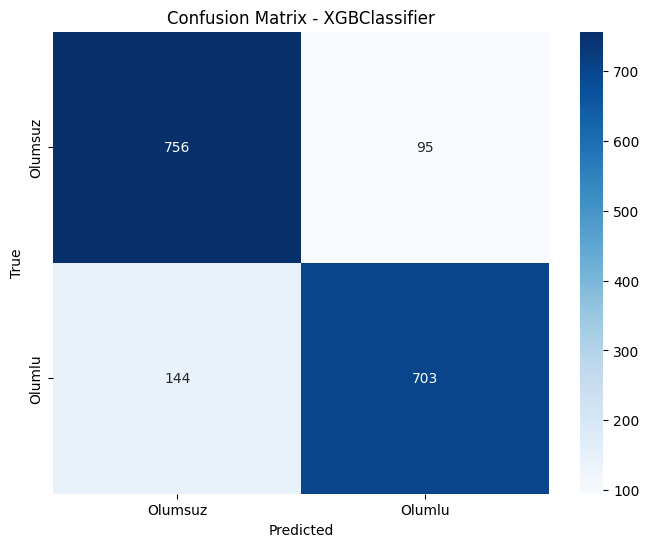

Best model: SVC with accuracy: 0.8916372202591284


In [6]:
models = [
    LogisticRegression(),
    SVC(kernel='linear'),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    MultinomialNB(),
    XGBClassifier()
]


def train_and_evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"Model: {model.__class__.__name__}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    # print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['Olumsuz', 'Olumlu']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Olumsuz', 'Olumlu'], yticklabels=['Olumsuz', 'Olumlu'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model.__class__.__name__}')
    plt.show()




# Evaluate models
best_model = None
best_accuracy = 0

for model in models:    
    train_and_evaluate_model(model, X_train_tfidf, X_test_tfidf, Y_tr, Y_te)
    
    accuracy = accuracy_score(Y_te, model.predict(X_test_tfidf))
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model


print(f"Best model: {best_model.__class__.__name__} with accuracy: {best_accuracy}")


In [18]:
# Create a pipeline with the best model
pipeline = Pipeline([
    ('vectorizer', tfidf),
    ('classifier', best_model)
])

# Train the pipeline on the entire dataset
pipeline.fit(veriseti['new_text'], veriseti['Durum'])


def predict_sentiment(text):
    processed_text = clean_and_normalize_text(text)
    vectorized_text = pipeline.named_steps['vectorizer'].transform([processed_text])
    
    # Predict the sentiment of the entire sentence
    sentence_prediction = pipeline.named_steps['classifier'].predict(vectorized_text)[0]
    sentence_prediction_label = 'Olumlu' if sentence_prediction == 1 else 'Olumsuz'
    
    # Convert the sparse matrix to a dense array
    vectorized_text_array = vectorized_text.toarray()[0]
    
    # Extract words
    words = tfidf.get_feature_names_out()
    filtered_words = [words[i] for i, value in enumerate(vectorized_text_array) if value > 0 and words[i] not in ineffective]
    
    # Predict sentiment for each word
    word_sentiments = {}
    for word in filtered_words:
        if len(word.split()) > 1:  # Check if the word is an n-gram
            word_vectorized = tfidf.transform([word])
            word_prediction = pipeline.named_steps['classifier'].predict(word_vectorized)[0]
            word_prediction_label = 'Olumlu' if word_prediction == 1 else 'Olumsuz'
            word_sentiments[word] = word_prediction_label
    
    return sentence_prediction_label, word_sentiments

# Test the function with your text
test_text = "Güzel ürün. Hızlı teslimat"
sentence_sentiment, word_sentiments = predict_sentiment(test_text)

# Print the sentiment of the entire sentence
print(f"Sentence sentiment: {sentence_sentiment}")

# Print the sentiment of individual words
print("Word sentiments:")
for word, sentiment in word_sentiments.items():
    print(f"{word}")

Sentence sentiment: Olumlu
Word sentiments:
güzel ürün
hızlı teslimat
ürün hızlı
